# SparkAmplify Code Challenge

### Description

We have 15,000 articles in our hands which are from N categories.

### Problem

1. Please plot the position of the articles in two dimensional space and cluster the articles in several groups. Then, you need to pick the representative article toward each group. (note: you have to explain the reason of picking group number)
2. Based on the 1, what are the top-5 keywords of each representative article.
3. Based on the 1 and 2, please rank the top-10 document order with the top-5 keywords from the representative article toward each group.
4. Based on the 1 and 2, please rank the top-10 document order with the content from the representative article toward each group.
5. Please combine both methods you applied in the 3 and 4 to output the similar format result.


### EDA

1. Missing article name (na): 397
2. Different article name but same contents. e.g. 1259184-1259200: 160
3. Aritcle name contains the different language e.g russian

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
articles = pd.read_csv("~/Downloads/articles_raw.csv")
articles

,id,title,text,date
0,1247638,Triple W to Feature DFree at CES 2019 - First ...,jan. according to the u. s. national institute...,2019-01-03
1,1247639,Pundi X Coin Review: Should You Invest in the ...,the npxs token developer aim to have ethereum ...,2019-01-06
2,1247641,Pundi X 1-Day Trading Volume Reaches $1.04 Mil...,pundi x (currency:npxs) traded 2. u dollar dur...,2019-01-02
3,1247642,Pundi X Hits Market Capitalization of $74.35 M...,pundi x (currency:npxs) traded 0. pm eastern o...,2019-01-04
4,1247643,Pundi X (NPXS) Market Cap Reaches $73.89 Million,pundi x (currency:npxs) traded down 0. u dolla...,2019-01-03
...,...,...,...,...
11182,1388717,NaN,microsoft for the mixed reality partnership pr...,2019-01-02
11183,1388718,NaN,ar (ar) app that convert any room to a virtual...,2019-01-09
11184,1388738,Intercellular is an Educational Experience Tak...,there nothing like a good educational vr (vr) ...,2019-02-13
11185,1388746,Wonderfall Mixes VR and Actual Reality For An ...,"it got a lot of vr and ar exhibit right now, n...",2019-01-30


In [3]:
dup = articles[articles.duplicated(subset=['text'])]

In [4]:
dup_id = dup.id.to_list()
na_id = articles[articles.title.isna()].id.to_list()

In [5]:
articles_uniq = articles[~articles.id.isin(na_id+dup_id)]
print("legnth: ", len(articles_uniq))

legnth:  10210


### Preprocessing

spacy: https://allenai.github.io/scispacy/

In [6]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models
import gensim
import spacy
import string
import pyLDAvis.gensim

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/yuzhe/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

[nltk_data] Downloading package wordnet to /Users/yuzhe/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [8]:
pattern = r'\b[^\d\W]+\b'
tokenizer = RegexpTokenizer(pattern)
en_stop = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [9]:
def normalizeText(data):
    raw = str(data).lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [raw for raw in tokens if not raw in en_stop]
    
    # lemmatize tokens
    lemma_tokens = [lemmatizer.lemmatize(tokens) for tokens in stopped_tokens]
    
    # remove word containing only single char
    new_lemma_tokens = [raw for raw in lemma_tokens if not len(raw) == 1]
    
    return new_lemma_tokens

In [10]:
texts = []
for row in articles_uniq.itertuples():
    texts.append(normalizeText(row[3]))

In [11]:
# nlp = en_core_web_sm.load()

# doc = nlp(articles_uniq.text[0])
# spacy_words = [token.text for token in doc]
# print(f"Tokenized words: {spacy_words}")

### Document Clustering - TF-IDF + KMeans

Dimension reduction to vis: pca v.s. t-SNE

In [12]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [13]:
articles_uniq['nor_text'] = texts
articles_uniq['nor_text'] = articles_uniq['nor_text'].copy().apply(lambda x: ' '.join(x))
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(articles_uniq.nor_text)
contents = tfidf.transform(articles_uniq.nor_text)

/Users/yuzhe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/yuzhe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=8000,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


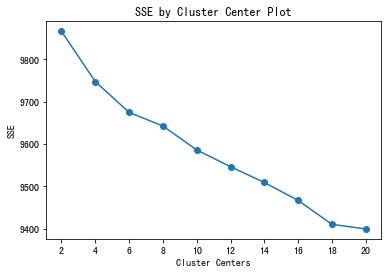

In [14]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(contents, 20)

In [15]:
clusters = MiniBatchKMeans(n_clusters=8, init_size=1024, batch_size=2048, random_state=20).fit_predict(contents)

/Users/yuzhe/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yuzhe/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


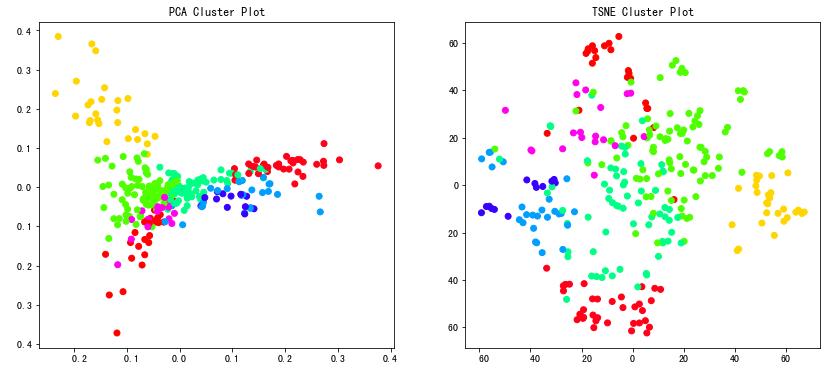

In [16]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(contents, clusters)

In [17]:
 def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(contents, clusters, tfidf.get_feature_names(), 5)


Cluster 0
camera,phone,device,android,google

Cluster 1
crypto,exchange,blockchain,cryptocurrency,bitcoin

Cluster 2
facebook,data,technology,said,company

Cluster 3
game,ha,year,team,wa

Cluster 4
wa,new,player,vr,game

Cluster 5
console,xbox,game,switch,nintendo

Cluster 6
di,la,app,apple,window

Cluster 7
wa,point,team,season,game


### Document Clustering - LDA

In [18]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
number_topics = 8
number_words = 5
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(contents)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, tfidf, number_words)

/Users/yuzhe/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/yuzhe/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/yuzhe/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/yuzhe/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/yuzhe/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/yuzhe/an

/Users/yuzhe/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/yuzhe/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/yuzhe/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/yuzhe/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/yuzhe/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/yuzhe/an

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=8, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

Topics found via LDA:

Topic #0:
pundi traded exchange nem ethereum

Topic #1:
game season team wa point

Topic #2:
blockchain ha company said wa

Topic #3:
device google drone technology phone

Topic #4:
la en que el del

Topic #5:
reserved obscene overstock digibyte dgb

Topic #6:
game nintendo xbox window app

Topic #7:
na iotex que da para


In [19]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

In [20]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=8, id2word = dictionary, passes=20)

In [21]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/Users/yuzhe/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/yuzhe/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/yuzhe/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.156748  0.051784       1        1  27.236572
1      0.174965  0.044110       2        1  22.748150
2      0.131667 -0.117006       3        1  20.125944
0      0.131789  0.119155       4        1  12.861133
5      0.053285  0.120594       5        1   7.809780
3      0.003040 -0.296422       6        1   6.349926
6     -0.366173 -0.006633       7        1   2.252765
4     -0.285321  0.084417       8        1   0.615727, topic_info=     Category          Freq            Term         Total  loglift  logprob
1352  Default  17494.000000            game  17494.000000  30.0000  30.0000
312   Default  11975.000000             one  11975.000000  29.0000  29.0000
271   Default  16730.000000              wa  16730.000000  28.0000  28.0000
113   Default   3480.000000  cryptocurrency   3480.000000  27.0000  27.0000
309   Default   5089.000000            last   5089.000000  26.0000  26.0000
...       ...           ...             ...           ...      ...      ...
323    Topic8    109.878311           total   1076.982300   2.8076  -4.9414
147    Topic8    144.434448              ha  17986.562500   0.2656  -4.6680
296    Topic8    123.428108             day   3782.711426   1.6676  -4.8252
305    Topic8    108.081490            hour   1284.409668   2.6150  -4.9579
271    Topic8    115.934074              wa  16730.333984   0.1182  -4.8878

[636 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
13850      1  0.053873   academy
13850      2  0.062161   academy
13850      6  0.882683   academy
283        1  0.441113  acquired
283        3  0.154986  acquired
...      ...       ...       ...
1913       3  0.094643     youre
1913       4  0.020725     youre
1913       5  0.004145     youre
11599      5  0.993743     zcash
86791      1  0.997971   zilingo

[1436 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 3, 1, 6, 4, 7, 5])

In [22]:
twords = {}
for i, tp in enumerate(ldamodel.show_topics(num_words=5)):
    twords[i] = re.sub('[^A-Za-z ]+', '', tp[1]).split('  ')

twords

{0: ['device', 'google', 'window', 'ha', 'also'],
 1: ['game', 'vr', 'one', 'like', 'wa'],
 2: ['game', 'wa', 'team', 'season', 'player'],
 3: ['wa', 'state', 'said', 'school', 'year'],
 4: ['pundi', 'exchange', 'traded', 'using', 'nem'],
 5: ['blockchain', 'cryptocurrency', 'bitcoin', 'ha', 'price'],
 6: ['de', 'di', 'la', 'un', 'il'],
 7: ['company', 'said', 'ha', 'technology', 'data']}

### Rank top 10 document order with top-5 keywords

In [23]:
from gensim import similarities

index = similarities.MatrixSimilarity(ldamodel[corpus])

In [24]:
print(index)

MatrixSimilarity<10210 docs, 8 features>


In [26]:
def get_similarity(lda, query_vector):
    index = similarities.MatrixSimilarity(lda[corpus])
    sims = index[query_vector]
    return sims

In [27]:
print("Top 10 documents with top-5 keywords")
for topic_i in range(len(twords)):
    print("topic {} 's keywords: {}".format(topic_i, twords[topic_i]))
    query = ldamodel[dictionary.doc2bow(twords[topic_i])]
    sims = get_similarity(ldamodel, query)
    sims = sorted(enumerate(sims), key=lambda item: -item[1]) # ranking
    print()
    for i in range(10):
        target = articles_uniq.iloc[sims[i][0], :]
        print("id: {} / title: {}".format(target['id'], target['title']))

Top 10 documents with top-5 keywords
topic 0 's keywords: ['device', 'google', 'window', 'ha', 'also']

id: 1258124 / title: 華碩推出一款有著 Surface 外型的 ASUS ROG Mothership 電競筆電 - 電腦王阿達
id: 1249578 / title: Google Emails Users About Private Data Exposed by Google+ API Bug
id: 1274944 / title: Brooklyn Dentist Used Uncertified Workers to Treat Patients
id: 1251825 / title: CES 2019：Razer Raptor桌機用螢幕發表 支援AMD Radeon FreeSync 支援1毫秒反應速率與144Hz更新率 - 癮科技 Cool3c
id: 1339680 / title: Vivaldi 2.3: Νέα έκδοση με αυτόματη στοίβαξη καρτελών
id: 1339346 / title: 2018 美國平均每支 iPhone 花 2,400 元買 App，遊戲比例最高
id: 1262042 / title: Hands On: Asus' Detachable Gaming Monster, the ROG Mothership
id: 1376137 / title: Radeon Pro Software for Enterprise 19.Q1 released
id: 1258968 / title: Apple Seeds Third Beta of macOS Mojave 10.14.3 Update to Developers and Public Beta Testers
id: 1348666 / title: Windows 10 Twitter app updates with DM and image improvements OnMSFT.com
topic 1 's keywords: ['game', 'vr', 'one', 'like', 